# EE4C12-Epileptic-Seizure-Detection-using-EEG


    
Group 16 Members:

    1. Zhixuan Ge  
    2. Yanqi Hong 

## 1. Program Preparation

### 1.1 Import Packages

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import random

# from sklearn.utils.validation import check_missing_values
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
# from sklearn.datasets import make_classification
# from collections import Counter

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = "cuda"
#device = "cpu"

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### 1.2 Import Data

In [3]:
#load data on Yanqi Hong's computer
data = pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q1\EE4C12 Machine Learning For Electrical Engineering\CodeLab\Project\S&S_SZD (1)\Data\Project_Data_EE4C12_S&S_SZD.csv')
data

,Patient,annotation,min|FP1-F7,min|F7-T3,min|T3-T5,min|T5-O1,min|FP2-F8,min|F8-T4,min|T4-T6,min|T6-O2,...,norm_power_HF|CZ-C4,norm_power_HF|C4-T4,norm_power_HF|FP1-F3,norm_power_HF|F3-C3,norm_power_HF|C3-P3,norm_power_HF|P3-O1,norm_power_HF|FP2-F4,norm_power_HF|F4-C4,norm_power_HF|C4-P4,norm_power_HF|P4-O2
0,258,1,50,61,57,53,39,35,39,35,...,0.016087,0.066920,0.102402,0.481384,0.690787,0.154544,0.062533,0.046460,0.066575,0.086999
1,258,1,48,62,60,46,38,35,39,33,...,0.024006,0.064857,0.031791,0.225788,0.409987,0.184671,0.071133,0.022369,0.079494,0.047536
2,258,1,51,60,59,45,38,36,40,36,...,0.037326,0.100177,0.050009,0.622584,0.394504,0.225516,0.050673,0.044906,0.102142,0.068105
3,258,1,49,58,56,42,36,36,41,37,...,0.027546,0.107883,0.014017,0.359140,0.276964,0.104977,0.018042,0.079467,0.078255,0.089385
4,258,1,45,57,61,41,35,37,41,37,...,0.036820,0.182520,0.031397,0.328354,0.156929,0.151952,0.047532,0.135071,0.098320,0.137701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55451,11580,-1,75,73,81,80,66,80,77,75,...,0.244334,0.625396,0.023821,0.058277,0.083594,0.114426,0.119654,0.295364,0.185930,0.199585
55452,11580,-1,74,74,77,71,79,75,82,77,...,0.588236,0.743060,0.076294,0.332341,0.228458,0.170603,0.351418,0.638666,0.490806,0.307429
55453,11580,-1,72,76,72,73,74,76,80,76,...,0.296041,0.770194,0.041190,0.090919,0.186074,0.216797,0.231053,0.770637,0.285257,0.413382
55454,11580,-1,77,82,74,75,82,85,80,76,...,0.440360,0.720855,0.026959,0.026340,0.077674,0.269610,0.186769,0.790173,0.473615,0.415771


In [83]:
# # load data on Zhixuan's computer
# data = pd.read_csv('D:\\User\Zhixuan Ge\Onedrive TUDelft\OneDrive - Delft University of Technology\Courses\ML for EE\SZD\S&S_SZD\Project_Data_EE4C12_S&S_SZD.csv')
# data

## 2. Data Preprocessing

### 2.1 Train-Test Split

In [4]:
# Not applied for the moment
# x is the features, y is the label
y = np.int32(data['annotation'].values)
X = data.iloc[:, 2:].values



#split the data into training and testing
Shuffle_state = 42
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=Shuffle_state)

print(X_train.shape)
print(X_test.shape)

#pca
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(X_train)
# X_train =pca.transform(X_train)
# X_test =pca.transform(X_test)
# print(X_train.shape)
# print(X_test.shape)

#k fold cross validation

(41592, 360)
(13864, 360)


In [5]:
#k fold cross validation
def Kfold_split(X_train, y_train, Shuffle_state):   # Split the data into training and validation sets
    #example : X_k_train, y_k_train, X_k_val, y_k_val = Kfold_split(X_train, y_train, Shuffle_state)
    kf = KFold(n_splits=5, random_state=Shuffle_state, shuffle=True)
    kf.get_n_splits(X_train)
    X_k_train = []
    y_k_train = []
    X_k_val = []
    y_k_val = []
    for train_index, val_index in kf.split(X_train):  # Split the data into training and validation sets
        X_k_train.append(X_train[train_index])
        y_k_train.append(y_train[train_index])
        X_k_val.append(X_train[val_index])
        y_k_val.append(y_train[val_index])
    return X_k_train, y_k_train, X_k_val, y_k_val



### 2.2 Scaling

In [7]:

#standardize the data
scaler = StandardScaler().fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# clf_etc = ExtraTreesClassifier(random_state=Shuffle_state).fit(X_train_scaled, y_train)
# # y_pred = clf_etc.predict(X_test)
# feature_importances = clf_etc.feature_importances_
# plt.bar(range(len(feature_importances)), feature_importances)
# plt.show()
# important_feature_indices=np.argsort(feature_importances)[::-1]
# for i in range(0,len(important_feature_indices)):
#     X_train_scaled[important_feature_indices[i]]= X_train_scaled[important_feature_indices[i]]**(100*feature_importances[important_feature_indices[i]])
#     X_test_scaled[important_feature_indices[i]]= X_test_scaled[important_feature_indices[i]]**(100*feature_importances[important_feature_indices[i]])
    



### 2.3 Oversampling and Undersampling

In [8]:
num_zero=np.sum(y_train==0)
num_one=np.sum(y_train==1)
num_negatives_one=np.sum(y_train==-1)
print('The number of 0 is', num_zero)
print('The number of 1 is', num_one)
print('The number of -1 is', num_negatives_one)

#undersampling
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=Shuffle_state)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# oversampling
sm = SMOTE(random_state=Shuffle_state)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

#Combination of over- and under-sampling
# smt = SMOTETomek(random_state=Shuffle_state)
# X_train_scaled, y_train = smt.fit_resample(X_train_scaled, y_train)

num_zero=np.sum(y_train==0)
num_one=np.sum(y_train==1)
num_negatives_one=np.sum(y_train==-1)

print('The number of 0 is', num_zero)
print('The number of 1 is', num_one)
print('The number of -1 is', num_negatives_one)

The number of 0 is 1469
The number of 1 is 18177
The number of -1 is 21946
The number of 0 is 21946
The number of 1 is 21946
The number of -1 is 21946


In [ ]:
y = np.int32(data['annotation'].values)
X = data.iloc[:, 2:].values

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [ ]:
n_p = data['annotation'].value_counts()[1]
n_n = data['annotation'].value_counts()[-1]
n_z = data['annotation'].value_counts()[0]

weights = np.array([n_n, n_z, n_p])
weights = weights / weights.sum()
weights = 1 / weights
weights = weights / weights.sum()

weights = {-1:weights[0], 0:weights[1], 1:weights[2]}

print(weights)

{-1: 0.05863727895765303, 0: 0.8704602962506767, 1: 0.07090242479167017}


## 3. Model Training

### 3.1 Try 1: logistic regression

In [ ]:
#Logistic regression
clf_lr = LogisticRegression(max_iter=1000, class_weight=weights).fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

NameError: name 'weights' is not defined

In [ ]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.4337132140796307
F1 score: 0.4337132140796307
Recall score: 0.4337132140796307
Precision score: 0.4337132140796307


In [ ]:
# not possible for multi-classification
'''#ROC curve

y_score_train = clf_lr.decision_function(X_train)
y_score_test = clf_lr.decision_function(X_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train, pos_label=clf_lr.classes_[1])
fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test, pos_label=clf_lr.classes_[1])

ax = plt.gca()
train_disp = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train)
train_disp.plot(ax, name='Train')

test_disp = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test)
test_disp.plot(ax, name='Test')

plt.legend()
plt.show()'''

"#ROC curve\n\ny_score_train = clf_lr.decision_function(X_train)\ny_score_test = clf_lr.decision_function(X_test)\nfpr_train, tpr_train, _ = roc_curve(y_train, y_score_train, pos_label=clf_lr.classes_[1])\nfpr_test, tpr_test, _ = roc_curve(y_test, y_score_test, pos_label=clf_lr.classes_[1])\n\nax = plt.gca()\ntrain_disp = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train)\ntrain_disp.plot(ax, name='Train')\n\ntest_disp = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test)\ntest_disp.plot(ax, name='Test')\n\nplt.legend()\nplt.show()"

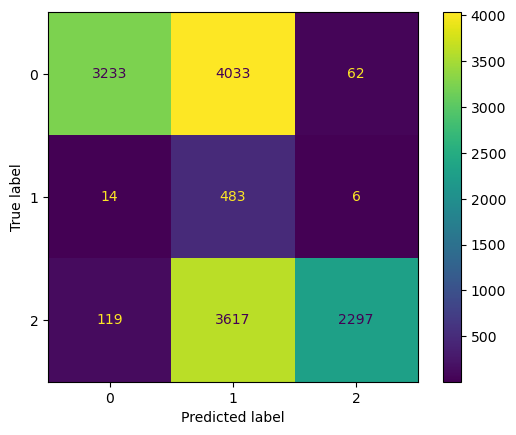

In [ ]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

In [ ]:
clf_svm = svm.SVC(kernel='linear', max_iter=2000,random_state=Shuffle_state, verbose=1, class_weight=weights).fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [41592, 65684]

In [ ]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.407530294287363
F1 score: 0.407530294287363
Recall score: 0.407530294287363
Precision score: 0.407530294287363


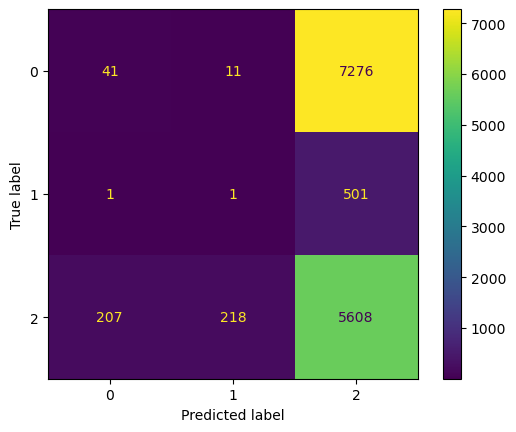

In [ ]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

### 3.2 Try 2: mlp (sklearn)


In [ ]:
# hl_size = (128, 64,64)
# #hl_size = (256, 256, 256, 128, 64)
# clf_mlp = MLPClassifier(hidden_layer_sizes=hl_size, activation='relu', solver='adam',
#                         alpha=0.0001, max_iter=1000, shuffle=True, random_state=Shuffle_state, verbose=True)
# clf_mlp.fit(X_train_scaled, y_train)
# y_pred = clf_mlp.predict(X_test_scaled)

mlp = MLPClassifier()

param_dist = {"hidden_layer_sizes": [(50,), (100,), (150,), (200,)],
              "activation": ["logistic", "tanh", "relu"],
              "solver": ["sgd", "adam"],
              "alpha": [0.0001, 0.001, 0.01],
              "learning_rate": ["constant", "adaptive"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=2, n_jobs=8)
random_search.fit(X_train_scaled, y_train)
y_pred = random_search.predict(X_test_scaled)

print(random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8711771494518177
F1 score: 0.8711771494518177
Recall score: 0.8711771494518177
Precision score: 0.8711771494518177


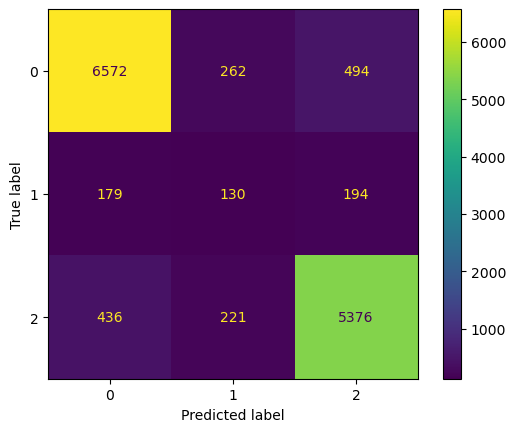

503
6033
7328


In [ ]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()


### 3.3 Try 3: Random Forest

In [ ]:
rf = RandomForestClassifier()


param_dist = {"max_depth": [3, None],
              "max_features": np.arange(1, 10),
              "min_samples_split": np.arange(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8)

random_search.fit(X_train_scaled, y_train)
y_pred = random_search.predict(X_test_scaled)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8868291979226774
F1 score: 0.8868291979226774
Recall score: 0.8868291979226774
Precision score: 0.8868291979226774


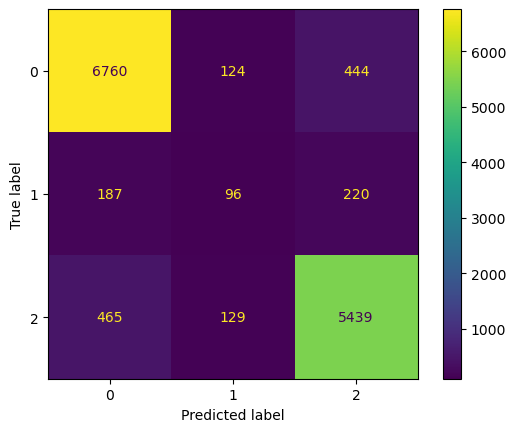

In [ ]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

### 3.4  Try 4: DNN (PyTorch)

In [10]:
# initialize the NN
class Data_tensor(Dataset):
    def __init__(self, X, y):
        X = np.float32(X)
        X = torch.from_numpy(X)
        y = np.longlong(y) - y.min()
        y = torch.from_numpy(y)
        
        self.X = X.to(device)
        self.y = y.to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    


In [11]:
# DNN class for random search
class DNN_rs(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNN_rs, self).__init__()
        depth=len(hidden_sizes)
        layers = []
        for i in range(depth):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i])) 
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear( hidden_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [12]:
# Test output for DNN_rs
input_size = X_train_scaled.shape[1]
output_size = 3
model_rs = DNN_rs(input_size, hidden_sizes=[100], output_size=output_size)
print(model_rs)

DNN_rs(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [13]:
# DNN class for normal training hidden sizes are fixed (512,512)
class DNN(nn.Module):
    def __init__(self, input_size=512, output_size=10):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = DNN(X.shape[1], 3).to(device)
print(model)

DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [14]:
# Train and test functions
def train(dataloader, model, loss_fn, optimizer):  
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print(pred.dtype)
        # print(y.dtype)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-classification
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.006) # Adam optimizer for normal training
optimizer_rs = torch.optim.Adam(model_rs.parameters(),weight_decay=0.005)   # Adam optimizer for random search

####################
Fold 1
Epoch 1
-------------------------------
loss: 0.130662  [ 1024/52670]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.142565 

Epoch 2
-------------------------------
loss: 0.120204  [ 1024/52670]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.148687 

Epoch 3
-------------------------------
loss: 0.126593  [ 1024/52670]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.154235 

Epoch 4
-------------------------------
loss: 0.114921  [ 1024/52670]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.151220 

Epoch 5
-------------------------------
loss: 0.133502  [ 1024/52670]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.156391 

Done!
DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
Accuracy: 0.954131227217497
F1 score: 0.954131227217497
Recall score: 0.954131227217497
Precis

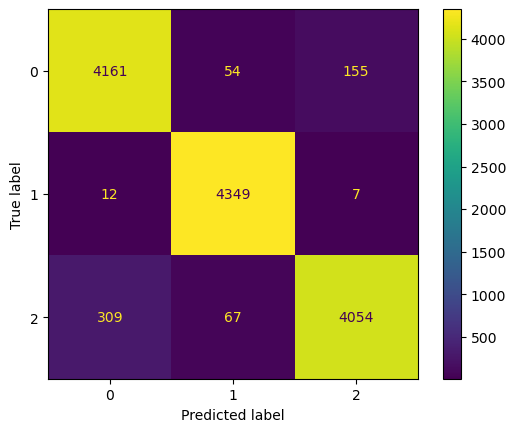

####################
####################
Fold 2
Epoch 1
-------------------------------
loss: 0.135339  [ 1024/52670]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.136037 

Epoch 2
-------------------------------
loss: 0.142869  [ 1024/52670]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.145098 

Epoch 3
-------------------------------
loss: 0.142618  [ 1024/52670]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.147763 

Epoch 4
-------------------------------
loss: 0.160832  [ 1024/52670]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.155728 

Epoch 5
-------------------------------
loss: 0.130939  [ 1024/52670]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.145509 

Done!
DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
Accuracy: 0.9573967193195626
F1 score: 0.9573967193195626
Recall score: 0

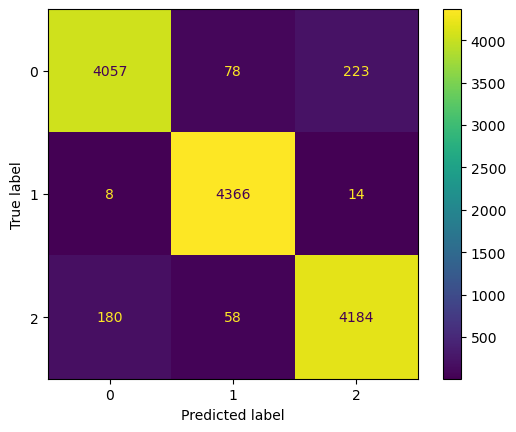

####################
####################
Fold 3
Epoch 1
-------------------------------
loss: 0.132220  [ 1024/52670]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.130997 

Epoch 2
-------------------------------
loss: 0.146562  [ 1024/52670]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.138634 

Epoch 3
-------------------------------
loss: 0.128253  [ 1024/52670]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.142752 

Epoch 4
-------------------------------
loss: 0.137423  [ 1024/52670]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.153097 

Epoch 5
-------------------------------
loss: 0.114598  [ 1024/52670]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.157461 

Done!
DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
Accuracy: 0.9508657351154314
F1 score: 0.9508657351154314
Recall score: 0

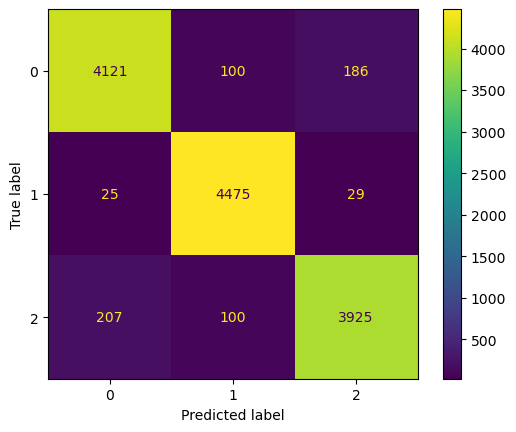

####################
####################
Fold 4
Epoch 1
-------------------------------
loss: 0.140757  [ 1024/52671]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.140719 

Epoch 2
-------------------------------
loss: 0.123229  [ 1024/52671]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.143613 

Epoch 3
-------------------------------
loss: 0.143179  [ 1024/52671]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.147763 

Epoch 4
-------------------------------
loss: 0.130969  [ 1024/52671]
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.154023 

Epoch 5
-------------------------------
loss: 0.133590  [ 1024/52671]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.156157 

Done!
DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
Accuracy: 0.9550391129338498
F1 score: 0.9550391129338498
Recall score: 0

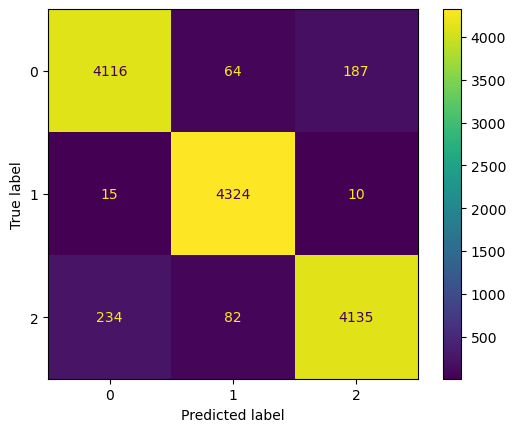

####################
####################
Fold 5
Epoch 1
-------------------------------
loss: 0.140600  [ 1024/52671]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.140700 

Epoch 2
-------------------------------
loss: 0.141974  [ 1024/52671]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.145169 

Epoch 3
-------------------------------
loss: 0.116952  [ 1024/52671]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.144839 

Epoch 4
-------------------------------
loss: 0.135706  [ 1024/52671]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.155605 

Epoch 5
-------------------------------
loss: 0.125617  [ 1024/52671]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.164322 

Done!
DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
Accuracy: 0.9476722108301056
F1 score: 0.9476722108301056
Recall score: 0

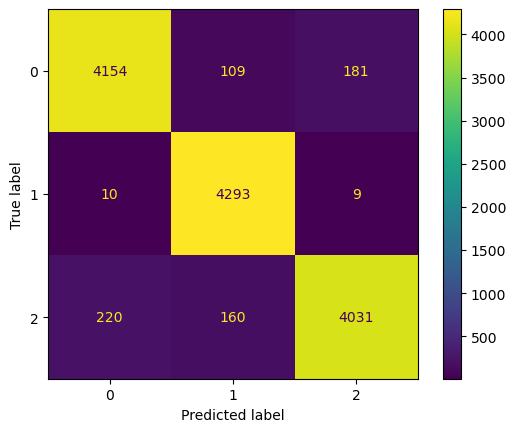

####################
####################
The average accuracy is 0.9530210010832892
####################
Accuracy: 0.8682919792267744
F1 score: 0.8682919792267744
Recall score: 0.8682919792267744
Precision score: 0.8682919792267744
zero value in validation set:  503


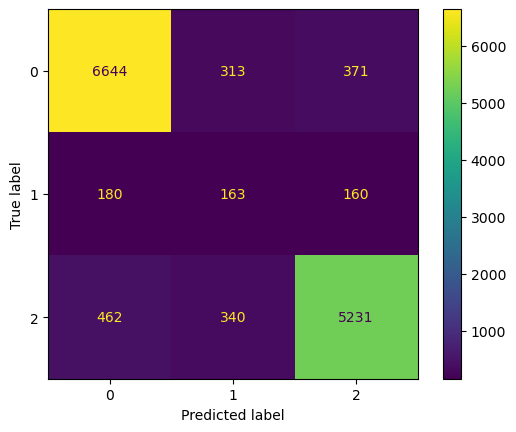

In [28]:
# K-fold cross validation for DNN
train_dataloader_list = []
val_dataloader_list = []
accuracy=[]
X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)
for i in range(len(X_k_train_list)):
    print("#"*20)
    print("Fold " + str(i+1))
    batch_size = 1024
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader = DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(valset_gpu, batch_size=batch_size, shuffle=False)
    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(val_dataloader, model, loss_fn)
    print("Done!")
    print(model)
    model.eval()
    pred = model(val_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
    # print(pred)
    true = val_dataloader.dataset[:][1].cpu().numpy()
    # print(true)
    #Performance metrics
    Accuracy_LR = accuracy_score(true, pred)
    F1_LR = accuracy_score(true, pred)
    Precision_LR = accuracy_score(true, pred)
    Recall_LR = accuracy_score(true, pred)
    accuracy.append(Accuracy_LR)
    print("Accuracy: " + str(Accuracy_LR))
    print("F1 score: " + str(F1_LR))
    print("Recall score: " + str(Recall_LR))
    print("Precision score: " + str(Precision_LR))
    print("zero value in validation set: ",sum(true==1))
    cm_2c = confusion_matrix(true, pred)
    cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
    plt.show()
    print("#"*20)
print("#"*20)

print("The average accuracy is", np.mean(accuracy))
print("#"*20)


testset_gpu = Data_tensor(X_test_scaled, y_test)
test_dataloader = DataLoader(testset_gpu, batch_size=batch_size, shuffle=False)
model.eval()
pred = model(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()
#Performance metrics
Accuracy_LR = accuracy_score(true, pred)
F1_LR = accuracy_score(true, pred)

Precision_LR = accuracy_score(true, pred)
Recall_LR = accuracy_score(true, pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

print("zero value in validation set: ",sum(true==1))
cm_2c = confusion_matrix(true, pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()



[[402, 193], [451, 508, 448], [353], [599, 335, 564], [364, 301], [212, 73, 323, 282], [508, 584, 191], [570, 134, 218, 245], [421, 365], [205, 352], [146, 163], [598, 464, 76], [95], [321], [265]]
####################
Fold 1
####################
********************
hidden size:  [402, 193]
learning rate:  0.0001
********************
DNN_rs(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=402, bias=True)
    (1): ReLU()
    (2): Linear(in_features=402, out_features=193, bias=True)
    (3): ReLU()
    (4): Linear(in_features=193, out_features=3, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 0.138752  [ 1024/52670]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.136524 

Epoch 2
-------------------------------
loss: 0.135889  [ 1024/52670]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.143142 

Epoch 3
-------------------------------
loss: 0.121377  [ 1024/52670]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.144775 

Epoch 4
------------------------

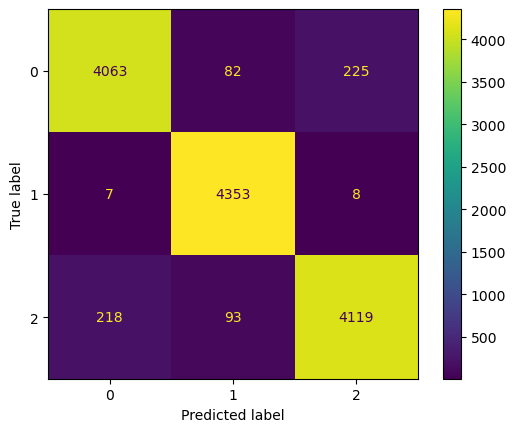

####################
####################
Fold 2
Epoch 1
-------------------------------
loss: 0.128555  [ 1024/52670]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.137880 

Epoch 2
-------------------------------
loss: 0.150005  [ 1024/52670]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.134556 

Epoch 3
-------------------------------
loss: 0.130386  [ 1024/52670]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.152114 

Epoch 4
-------------------------------
loss: 0.153791  [ 1024/52670]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.150322 

Epoch 5
-------------------------------
loss: 0.155806  [ 1024/52670]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.153734 

Epoch 6
-------------------------------
loss: 0.125635  [ 1024/52670]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.150934 

Epoch 7
-------------------------------
loss: 0.137584  [ 1024/52670]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.156902 

Epoch 8
-------------------------------
loss: 0.146084  [ 1024/52670]
Test Error: 
 Accuracy: 95.

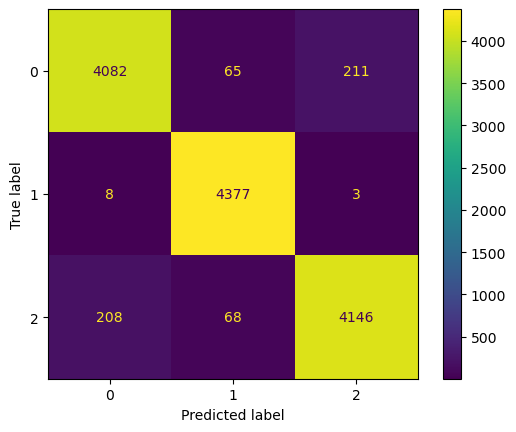

####################
####################
Fold 3
Epoch 1
-------------------------------
loss: 0.144794  [ 1024/52670]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.138840 

Epoch 2
-------------------------------
loss: 0.143385  [ 1024/52670]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.138257 

Epoch 3
-------------------------------
loss: 0.128418  [ 1024/52670]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.143114 

Epoch 4
-------------------------------
loss: 0.122111  [ 1024/52670]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.147851 

Epoch 5
-------------------------------
loss: 0.134491  [ 1024/52670]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.147818 

Epoch 6
-------------------------------
loss: 0.117977  [ 1024/52670]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.145202 

Epoch 7
-------------------------------
loss: 0.142375  [ 1024/52670]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.149569 

Epoch 8
-------------------------------
loss: 0.113912  [ 1024/52670]
Test Error: 
 Accuracy: 95.

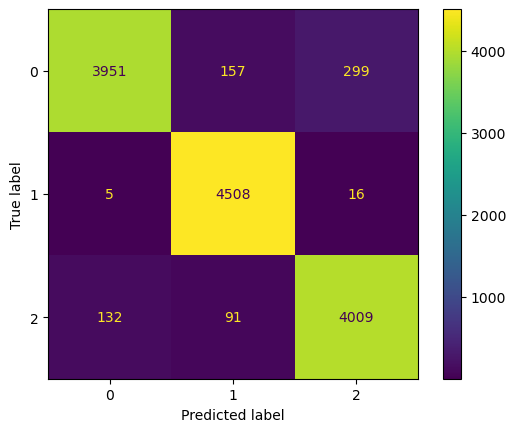

####################
####################
Fold 4
Epoch 1
-------------------------------
loss: 0.137129  [ 1024/52671]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.140037 

Epoch 2
-------------------------------
loss: 0.133410  [ 1024/52671]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.148603 

Epoch 3
-------------------------------
loss: 0.119717  [ 1024/52671]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.147272 

Epoch 4
-------------------------------
loss: 0.125578  [ 1024/52671]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.148765 

Epoch 5
-------------------------------
loss: 0.131567  [ 1024/52671]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.151947 

Epoch 6
-------------------------------
loss: 0.130802  [ 1024/52671]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.148502 

Epoch 7
-------------------------------
loss: 0.124873  [ 1024/52671]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.156801 

Epoch 8
-------------------------------
loss: 0.122254  [ 1024/52671]
Test Error: 
 Accuracy: 95.

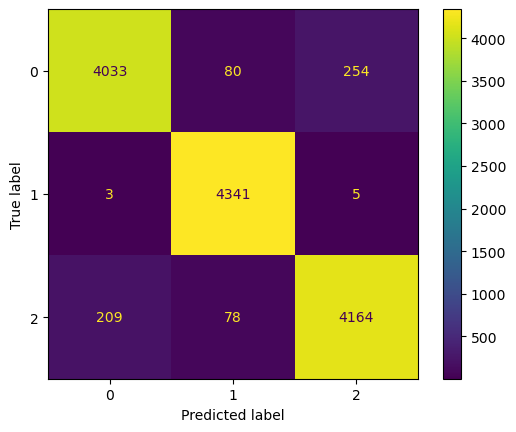

####################
####################
Fold 5
Epoch 1
-------------------------------
loss: 0.119963  [ 1024/52671]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.151092 

Epoch 2
-------------------------------
loss: 0.144183  [ 1024/52671]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.149586 

Epoch 3
-------------------------------
loss: 0.138917  [ 1024/52671]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.152773 

Epoch 4
-------------------------------
loss: 0.131605  [ 1024/52671]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.155432 

Epoch 5
-------------------------------
loss: 0.134300  [ 1024/52671]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.154465 

Epoch 6
-------------------------------
loss: 0.118884  [ 1024/52671]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.159901 

Epoch 7
-------------------------------
loss: 0.120644  [ 1024/52671]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.154557 

Epoch 8
-------------------------------
loss: 0.124713  [ 1024/52671]
Test Error: 
 Accuracy: 94.

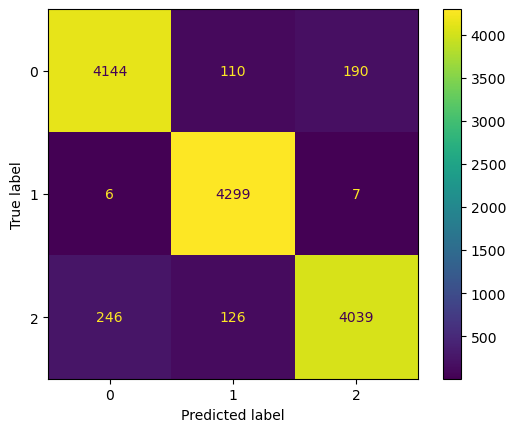

####################
####################
The best hidden layer size is [402, 193]
The best learning rate is 0.0001
The best average accuracy is 0.9537652918056768
####################
Accuracy: 0.8739180611656088
F1 score: 0.8739180611656088
Recall score: 0.8739180611656088
Precision score: 0.8739180611656088
zero value in validation set:  503


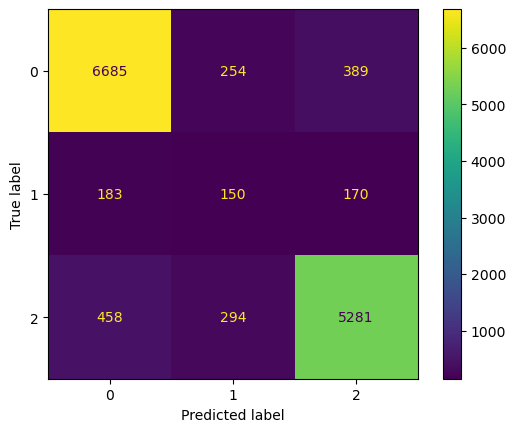

In [31]:
# Random search for DNN
min_width=60
max_width=600
min_depth=1
max_depth=5
hidden_layer_number=15

param_dist = {"hidden_sizes": [[randint(min_width,max_width).rvs() for i in range(randint(min_depth, max_depth).rvs())] for j in range(hidden_layer_number)], 
                "alpha": [0.0001, 0.001, 0.01], # L2 regularization
              }

print(param_dist["hidden_sizes"])

train_dataloader_list = []
val_dataloader_list = []

accuracy_list=[]

parameters_list=[]

X_k_train_list, y_k_train_list, X_k_val_list, y_k_val_list = Kfold_split(X_train_scaled, y_train, Shuffle_state)   # K-fold cross validation for DNN
for i in range(len(X_k_train_list)):

    
    print("#"*20)
    print("Fold " + str(i+1))
    print("#"*20)

    batch_size = 1024
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader = DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(valset_gpu, batch_size=batch_size, shuffle=False)
    

    for i in range(hidden_layer_number):
        hidden_layer=param_dist['hidden_sizes'][i]
        for j in param_dist['alpha']:
            alpha=j
            print("*"*20)
            print("hidden size: ", hidden_layer)
            print("learning rate: ", alpha)
            print("*"*20)

            parameters_list.append([hidden_layer,alpha])
 
            optimizer_rs.lr = alpha
            model_rs = DNN_rs(X.shape[1], hidden_layer, 3).to(device)
            print(model_rs)

            epochs = 5
            for t in range(epochs):
                print(f"Epoch {t+1}\n-------------------------------")
                train(train_dataloader, model, loss_fn, optimizer)
                test(validation_dataloader, model, loss_fn)
            print("Done!")

            model_rs.eval()
            pred = model(validation_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
            true = validation_dataloader.dataset[:][1].cpu().numpy()
            # Performance metrics
            Accuracy_LR = accuracy_score(true, pred)
            F1_LR = accuracy_score(true, pred)
            Precision_LR = accuracy_score(true, pred)
            Recall_LR = accuracy_score(true, pred)
        

            accuracy_list.append(Accuracy_LR)
            print("Accuracy: " + str(Accuracy_LR))
            print("F1 score: " + str(F1_LR))
            print("Recall score: " + str(Recall_LR))
            print("Precision score: " + str(Precision_LR))

# Find the maxmium average accuracy for each combination of hyperparameters
mean_accuracy_list=[]
paramaters_combinition=[]
combinition=[]
for i in range(len(parameters_list)):
    if i < hidden_layer_number* len(param_dist['alpha']):
        for j in  range(len(parameters_list)):
            if parameters_list[i]==parameters_list[j]:
                combinition.append(j)

        accuracy_combinition=[]
        for k in combinition:
            accuracy_combinition.append(accuracy_list[k])
        
        mean_accuracy=np.mean(accuracy_combinition)
        mean_accuracy_list.append(mean_accuracy)
        paramaters_combinition.append(parameters_list[i])

hidden_layer=paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][0]
alpha=paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][1]



#Show the coonfusion matrix for the best hyperparameters
print("#"*20)
print("Confusion matrix for the best hyperparameters in each fold")
print("#"*20)
print("hidden size: ", hidden_layer)
print("learning rate: ", alpha)
optimizer_rs.lr = alpha
model_rs = DNN_rs(X.shape[1], hidden_layer, 3).to(device)
print(model_rs)

for i in range(len(X_k_train_list)):

    print("#"*20)
    print("Fold " + str(i+1))
    batch_size = 1024
    trainset_gpu = Data_tensor(X_k_train_list[i], y_k_train_list[i])
    valset_gpu = Data_tensor(X_k_val_list[i], y_k_val_list[i])
    train_dataloader = DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(valset_gpu, batch_size=batch_size, shuffle=False)
    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(validation_dataloader, model, loss_fn)
    print("Done!")

    model_rs.eval()
    pred = model(validation_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
    true = validation_dataloader.dataset[:][1].cpu().numpy()

    #Performance metrics
    Accuracy_LR = accuracy_score(true, pred)
    F1_LR = accuracy_score(true, pred)
    Precision_LR = accuracy_score(true, pred)
    Recall_LR = accuracy_score(true, pred)

    print("Accuracy: " + str(Accuracy_LR))
    print("F1 score: " + str(F1_LR))
    print("Recall score: " + str(Recall_LR))
    print("Precision score: " + str(Precision_LR))


    print("one value in validation set: ",sum(true==2))
    print("zero value in validation set: ",sum(true==1))
    print("negative one value in validation set: ",sum(true==0))

    cm_2c = confusion_matrix(true, pred)
    cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
    plt.show()
    print("#"*20)


#Display the best hyperparameters and the corresponding average accuracy
print("#"*20)
print("The best hidden layer size is", paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][0])
print("The best learning rate is", paramaters_combinition[mean_accuracy_list.index(max(mean_accuracy_list))][1])
print("The best average accuracy is", max(mean_accuracy_list))
print("#"*20)


#evaluation on test set
optimizer_rs.lr = alpha
model_rs = DNN_rs(X.shape[1], hidden_layer, 3).to(device)

testset_gpu = Data_tensor(X_test_scaled, y_test)
test_dataloader = DataLoader(testset_gpu, batch_size=batch_size, shuffle=False)
model_rs.eval()
pred = model(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()
#Performance metrics
Accuracy_LR = accuracy_score(true, pred)
F1_LR = accuracy_score(true, pred)

Precision_LR = accuracy_score(true, pred)
Recall_LR = accuracy_score(true, pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

print("zero value in validation set: ",sum(true==1))
cm_2c = confusion_matrix(true, pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()


In [23]:
# mean_accuracy_list=[]
# paramaters_combinition=[]
# parameters1=np.array(parameters)
# print(parameters)
# print(accuracy)
# print(np.where(parameters1 == parameters1[0]))

# # for i in range(len(parameters)):
# #     if i < hidden_layer_number* len(param_dist['alpha']):
# #         combinition=np.where(parameters==parameters[i])[0]

# #         accuracy_combinition=[]
# #         for j in combinition[0]:
# #             accuracy_combinition.append(accuracy[j])
        
# #         mean_accuracy=np.mean(accuracy_combinition)
# #         mean_accuracy_list.append(mean_accuracy)
# #         paramaters_combinition.append(parameters[i])



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader_list[1], model, loss_fn, optimizer)
#     test(val_dataloader_list[1], model, loss_fn)
# print("Done!")

In [ ]:
X_k_train, y_k_train, X_k_val, y_k_val = Kfold_split(X_train_scaled, y_train, Shuffle_state)

epochs = 5
for j in range(len(train_dataloader_list)):
    print("#"*20)
    print("K-fold: " + str(j+1))
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader_list[j], model, loss_fn, optimizer)
        test(val_dataloader_list[j], model, loss_fn)
    print("Done!")
    model.eval()
    pred = model(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
    true = test_dataloader.dataset[:][1].cpu().numpy()
    #Performance metrics
    Accuracy_LR = accuracy_score(true, pred)
    F1_LR = accuracy_score(true, pred)
    Precision_LR = accuracy_score(true, pred)
    Recall_LR = accuracy_score(true, pred)
    print("Accuracy: " + str(Accuracy_LR))
    print("F1 score: " + str(F1_LR))
    print("Recall score: " + str(Recall_LR))
    print("Precision score: " + str(Precision_LR))
    cm_2c = confusion_matrix(true, pred)
    cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
    plt.show()
    print("#"*20)
        

NameError: name 'train_dataloader_list' is not defined

In [ ]:
# epochs = 100
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     t_cur = t % 5
#     train(train_dataloader_list[t_cur], model, loss_fn, optimizer)
#     test(val_dataloader_list[t_cur], model, loss_fn)
# print("Done!")

In [ ]:
model.eval()
pred = model(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()

In [ ]:
#Performance metrics
Accuracy_LR = accuracy_score(true, pred)
F1_LR = accuracy_score(true, pred)
Precision_LR = accuracy_score(true, pred)
Recall_LR = accuracy_score(true, pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8392960184650894
F1 score: 0.8392960184650894
Recall score: 0.8392960184650894
Precision score: 0.8392960184650894


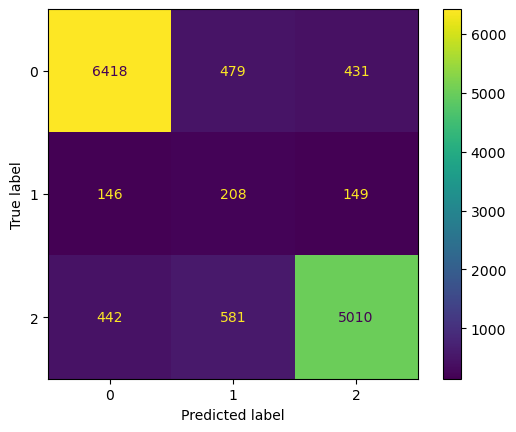

In [ ]:
#Confusion Matrix
cm_2c = confusion_matrix(true, pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

In [ ]:
print(sum(y_test==1))
print(sum(y_test==-1))
print(sum(y_test==0))


6033
7328
503


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.datasets import load_digits
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# digits = load_digits()
# X, y = digits.data, digits.target

# # 定义DNN模型
# class DNN(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size):
#         super(DNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
#         self.fc_out = nn.Linear(hidden_sizes[-1], output_size)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         for layer in self.hidden_layers:
#             out = layer(out)
#             out = self.relu(out)
#         out = self.fc_out(out)
#         return out

# # 定义参数空间
# param_dist = {"hidden_sizes": [randint(50, 200) for i in range(1, 6)],
#               "learning_rate": [0.001, 0.01, 0.1],
#               "batch_size": randint(16, 128)}

# # 创建随机搜索对象
# input_size = X.shape[1]
# output_size = len(set(y))
# dnn = DNN(input_size, hidden_sizes=[100], output_size=output_size)
# optimizer = optim.Adam(dnn.parameters())
# criterion = nn.CrossEntropyLoss()
# rs = RandomizedSearchCV(dnn, param_distributions=param_dist, n_iter=10,
#                         cv=5, scoring='accuracy', random_state=42)

# # 进行随机搜索
# for i, (train_idx, test_idx) in enumerate(rs.cv.split(X, y)):
#     X_train, y_train = torch.tensor(X[train_idx], dtype=torch.float32), torch.tensor(y[train_idx], dtype=torch.long)
#     X_test, y_test = torch.tensor(X[test_idx], dtype=torch.float32), torch.tensor(y[test_idx], dtype=torch.long)

#     # 设置超参数
#     params = rs.cv_results_['params'][i]
#     dnn.hidden_sizes = [params['hidden_sizes'] for i in range(1, 6)]
#     optimizer.lr = params['learning_rate']
#     batch_size = params['batch_size']

#     # 训练模型
#     train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
#                                                batch_size=batch_size, shuffle=True)
#     for epoch in range(10):
#         for batch_idx, (data, target) in enumerate(train_loader):
#             optimizer.zero_grad()
#             output = dnn(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()

#     # 在测试集上评估模型
#     y_pred = dnn(X_test).argmax(dim=1)
#     accuracy = (y_pred == y_test).float().mean().item()
#     rs.cv_results_['split%d_test_score' % i] = accuracy

# # 打印最优的超参数组合和对应的得分
# print("Best parameters:", rs.best_params_)
# print("Best score:", rs.best_score_)

## 4. Model Evaluation